# Random Forest

### Requirements

In [49]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import torch
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sentence_transformers import SentenceTransformer

from utils import (CoreXProbsFactory, LDAProbs, SyntaxFactory, preprocess,
                   tokenize)

data_dir = Path(".")
model_dir = Path("/home/iailab36/iser/models")

SEED = 1337
COREX_HIDDEN = 64
VEC_FEAT = 10_000

In [28]:
# Load benchmark dataset
train_data = pd.read_feather(data_dir / "stsbenchmark" / "sts-train.feather")
val_data = pd.read_feather(data_dir / "stsbenchmark" / "sts-dev.feather")
test_data = pd.read_feather(data_dir / "stsbenchmark" / "sts-test.feather")

train_data = pd.concat([train_data, val_data]).reset_index(drop=True)

## Pre-compute features

In [42]:
features_train = []
features_val = []

### topic model features

In [43]:
get_topic_probs = CoreXProbsFactory(
    vectorizer_path=model_dir / f"sts_vec={VEC_FEAT}",
    corex_name=f"corex_n_hidden={COREX_HIDDEN}_iter=7",
)

# get_topic_probs = LDAProbs(model_dir / f"sts_lda_hidden={COREX_HIDDEN}")

In [44]:
# compute topic probabilities
topic_probs_train_1 = get_topic_probs(train_data.s1)
topic_probs_train_2 = get_topic_probs(train_data.s2)
topic_probs_test_1 = get_topic_probs(test_data.s1)
topic_probs_test_2 = get_topic_probs(test_data.s2)
# concatenate topics of the two sentences
topic_probs_train = np.concatenate([topic_probs_train_1, topic_probs_train_2], axis=1)
topic_probs_test = np.concatenate([topic_probs_test_1, topic_probs_test_2], axis=1)
# add to features list
features_train.append(topic_probs_train)
features_val.append(topic_probs_test)

### syntax features

In [45]:
# get_syntax_deps = SyntaxFactory()
# # compute syntax tokens
# syntax_train_1 = get_syntax_deps(train_data.s1)
# syntax_train_2 = get_syntax_deps(train_data.s2)
# syntax_test_1 = get_syntax_deps(test_data.s1)
# syntax_test_2 = get_syntax_deps(test_data.s2)
# # mask matching syntax
# syntax_train = (syntax_train_1 == syntax_train_2).astype(int)
# syntax_test = (syntax_test_1 == syntax_test_2).astype(int)
# # append to features list
# features_train.append(syntax_train)
# features_val.append(syntax_test)

## Training without data augmentation

In [46]:
# create input vectors
X_train = np.concatenate(features_train, axis=1)
X_test = np.concatenate(features_val, axis=1)
# create targets
y_train = train_data.score
y_test = test_data.score
print("X_train:", X_train.shape)

X_train: (7030, 128)


In [47]:
random_forest = lambda SEED: RandomForestRegressor(criterion="squared_error", n_estimators=100, random_state=SEED)
decision_tree = lambda SEED: DecisionTreeRegressor(random_state=SEED, max_depth=5)
mlp = lambda SEED: MLPRegressor((512, 256), random_state=SEED)

In [48]:
np.random.seed(SEED)
perm = np.random.permutation(X_train.shape[0])
X_train_ = X_train[perm]
y_train_ = y_train[perm]

model = random_forest(SEED)
model.fit(X_train_, y_train_)

# evaluate model
spearman_train = spearmanr(model.predict(X_train), y_train)[0]
spearman_test = spearmanr(model.predict(X_test), y_test)[0]

print(f"SpearmanRank-train: {spearman_train:.4f},\t SpearmanRank-test: {spearman_test:.4f}")

SpearmanRank-train: 0.9837,	 SpearmanRank-test: 0.5062


## Training with data augmentation

In [10]:
# load augmentation dataset
aug_data = pd.read_feather(data_dir / "stsbenchmark" / "df_augment.feather")

features_aug = []

In [11]:
# get topics of the augmented sentences
topic_probs_augmented = np.concatenate([
    topic_probs_train_1[aug_data.idx1],
    topic_probs_train_2[aug_data.idx2]
], axis=1)
features_aug.append(topic_probs_augmented)

In [12]:
# # syntax features
# syntax_aug = (syntax_train_1[aug_data.idx1] == syntax_train_2[aug_data.idx2]).astype(int)
# features_aug.append(syntax_aug)

In [13]:
# create inputs / targets of augmented dataset
X_aug = np.concatenate(features_aug, axis=1)
y_aug = aug_data.score
print(f"#augmented: {y_aug.shape[0]}")

X_train_w_aug = np.concatenate([X_train, X_aug])
y_train_w_aug = np.concatenate([y_train, y_aug])
print(f"#(train+augmented): {y_train_w_aug.shape[0]}")

#augmented: 438
#(train+augmented): 7468


In [14]:
np.random.seed(SEED)
perm = np.random.permutation(X_train_w_aug.shape[0])
X_train_w_aug_ = X_train_w_aug[perm]
y_train_w_aug_ = y_train_w_aug[perm]

model = random_forest(SEED)
model.fit(X_train_w_aug_, y_train_w_aug_)

# evaluate model
spearman_train = spearmanr(model.predict(X_train), y_train)[0]
spearman_test = spearmanr(model.predict(X_test), y_test)[0]

print(f"SpearmanRank-train: {spearman_train:.4f},\t SpearmanRank-test: {spearman_test:.4f}")

SpearmanRank-train: 0.9809,	 SpearmanRank-test: 0.5136


## Qualitative analysis

In [15]:
# # unit vectors
# x1 = topic_probs_train_1 / np.linalg.norm(topic_probs_train_1, axis=1)[:, None]
# x2 = topic_probs_train_2 / np.linalg.norm(topic_probs_train_2, axis=1)[:, None]

# y_naiv = (x1[:, None, ...] @ x2[..., None]).squeeze()

In [16]:
# from scipy.stats import wasserstein_distance
# from sklearn.preprocessing import MinMaxScaler

# # softmax
# x1 = np.exp(topic_probs_train_1)/np.exp(topic_probs_train_1).sum(0)
# x2 = np.exp(topic_probs_train_2)/np.exp(topic_probs_train_2).sum(0)

# dists = np.array([wasserstein_distance(x1[i], x2[i]) for i in range(x1.shape[0])])

# mms = MinMaxScaler()
# y_naiv = mms.fit_transform(dists.reshape(-1, 1)).squeeze()

In [54]:
vectorizer = TfidfVectorizer()
# vectorizer = CountVectorizer()
vectorizer.fit(pd.concat([train_data.s1, train_data.s2]).apply(preprocess))
bow1 = vectorizer.transform(test_data.s1.apply(preprocess)).toarray()
bow2 = vectorizer.transform(test_data.s2.apply(preprocess)).toarray()

bow1 = bow1 / np.linalg.norm(bow1, axis=1)[:, None]
bow2 = bow2 / np.linalg.norm(bow2, axis=1)[:, None]

y_naiv = (bow1[:, None, ...] @ bow2[..., None]).squeeze()

spearman_val = spearmanr(y_naiv, y_test)[0]
print(f"Naive SpearmanRank-val: {spearman_val:.4f}")

Naive SpearmanRank-val: 0.7215


In [18]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"using device: {device}")

# load sbert model
sbert = SentenceTransformer("stsb-mpnet-base-v2")

# compute sentence embeddings with sbert
emb_1 = sbert.encode(test_data.s1, convert_to_tensor=True, device=device)
emb_2 = sbert.encode(test_data.s2, convert_to_tensor=True, device=device)

# compute similarity scores via cosine similarity
emb_1 = F.normalize(emb_1)
emb_2 = F.normalize(emb_2)
y_pred_sbert = (emb_1.unsqueeze(1) @ emb_2.unsqueeze(2)).squeeze(1).cpu().numpy()
# scale scores to [0, 1]
y_pred_sbert = MinMaxScaler().fit_transform(y_pred_sbert).squeeze()

spearman_val = spearmanr(y_pred_sbert, y_test)[0]
print(f"S-BERT SpearmanRank-val: {spearman_val:.4f}")

using device: cpu
S-BERT SpearmanRank-val: 0.8958


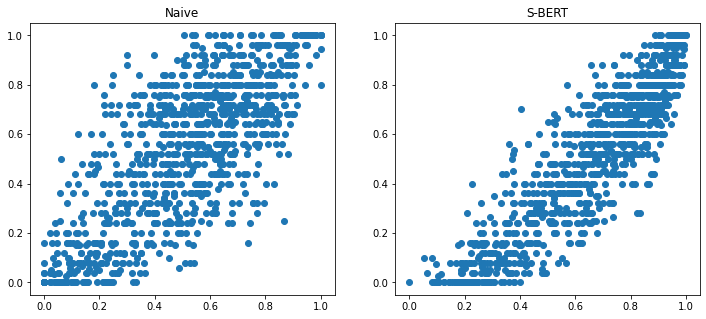

In [19]:
_, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(y_naiv, y_test)
ax[0].set_title("Naive")
ax[1].scatter(y_pred_sbert, y_test)
ax[1].set_title("S-BERT")
plt.show()

In [20]:
y_pred = model.predict(X_test)
spearman_val = spearmanr(y_pred, y_test)[0]
print(f"Topic Modeling SpearmanRank-val: {spearman_val:.4f}")

Topic Modeling SpearmanRank-val: 0.5136


In [52]:
df = test_data[["s1", "s2"]].copy()
df["s1_processed"] = df.s1.apply(preprocess)
df["s2_processed"] = df.s2.apply(preprocess)
df["y_true"] = y_test
df["y_pred"] = y_pred
df["y_naiv"] = y_naiv
# df[["root", "nsubj", "dobj"]] = [pd.Series(s) for s in syntax_test]

In [53]:
df[(df.y_true - df.y_naiv).abs() > 0.4]

,s1,s2,s1_processed,s2_processed,y_true,y_pred,y_naiv
4,A man is playing a harp.,A man is playing a keyboard.,a man is play a harp,a man is play a keyboard,0.3000,0.558920,0.750000
9,A man is playing a guitar.,A man is playing a trumpet.,a man is play a guitar,a man is play a trumpet,0.3428,0.535507,0.750000
10,A man is playing a guitar.,A man is playing a trumpet.,a man is play a guitar,a man is play a trumpet,0.3428,0.535507,0.750000
12,A man is cycling.,A man is talking.,a man is cycl,a man is talk,0.1200,0.467463,0.666667
21,The woman is styling her hair.,The woman is slicing herbs.,the woman is style her hair,the woman is slice herb,0.0400,0.497726,0.547723
...,...,...,...,...,...,...,...
1067,Bomber strikes near Pakistan army HQ,Bombing Outside Restaurant in Pakistan Wounds 15,bomber strike near pakistan armi hq,bomb outsid restaur in pakistan wound num,0.6000,0.578907,0.154303
1077,Headlines in major Iranian newspapers on Dec 14,Headlines in major Iranian newspapers on July 29,headlin in major iranian newspap on dec num,headlin in major iranian newspap on juli num,0.4000,0.602673,0.875000
1086,Strong new quake hits shattered Pak region,6.8 quake in shattered Pakistan region,strong new quak hit shatter pak region,num quak in shatter pakistan region,0.8800,0.808604,0.462910
1089,"3 dead, 4 missing in central China constructio...","One dead, 8 missing in Vietnam boat accident",num dead num miss in central china construct a...,one dead num miss in vietnam boat accid,0.0800,0.600208,0.639602


In [23]:
# "ad" in get_topic_probs.vectorizer.get_feature_names()

### Naive cosine similarity

In [24]:
# import spacy
# nlp = spacy.load("en_core_web_lg", exclude=["ner"])

In [25]:
# df["tok2vec"] = df[["s1", "s2"]].apply(lambda row: nlp(row.s1).similarity(nlp(row.s2)), axis=1)
# print(f"SpearmanRank-val: {spearmanr(df.tok2vec, df.y_true)[0]:.4f}")

In [26]:
# doc = nlp("Blue and red plane in mid-air flight.")
# print("\t".join([token.dep_ for token in doc]))
# print("\t".join([token.lemma_ for token in doc]))